In this study, there were 88 soil samples collected from North and South America.  Each of these soil samples had a pH measurement. From this [paper](http://www.ncbi.nlm.nih.gov/pubmed/19502440), it was observed that pH plays a primary role in community assemblage.  Here, we will show that pH by itself can actually predict the microbial abundances, using balance trees.

In [1]:
import pandas as pd

In [2]:
!qiime tools import --input-path 238_otu_table.biom \
                    --output-path 88soils.biom.qza \
                    --type FeatureTable[Frequency]

Now we will be filtering out OTUs that are lower abundance.  We'll set the threshold to be __100__ reads.
This is because there is going to be a lot of garbage OTUs due to contamination, sequencing error, or clustering errors.  We feel that the 100 read filter is conservative enough to demonstrate the utility of this tool.  Of course, this threshold depends on the dataset, and we suggest tinkering around with this threshold.

Samples and OTUS with fewer than 100 reads can be filtered as follows.

In [3]:
!qiime feature-table filter-features \
                    --i-table 88soils.biom.qza \
                    --o-filtered-table 88soils_filt100.biom.qza \
                    --p-min-frequency 100

Saved FeatureTable[Frequency] to: 88soils_filt100.biom.qza


Now we will build a tree based on the pH values, since in previous work it was observed that pH was the major driving
factor behind the community dissimilarity.

In [4]:
!qiime gneiss gradient-clustering \
                    --i-table 88soils_filt100.biom.qza \
                    --m-gradient-file 88soils_metadata.txt \
                    --m-gradient-category ph \
                    --o-clustering ph_tree.nwk.qza \
                    --p-no-weighted

Error: no such option: --p-weighted


The tree will give us information about how the OTUs partition.  In this case, the tree groups together organisms that
live in similar pH environments.  To get a better idea about how these organisms, let's visualize these partitions on a heatmap.  To this let's first categorize the samples by their measured pH.

In [5]:
mapping = pd.read_table('88soils_metadata.txt', index_col=0)
mapping['ph_rounded'] = mapping.ph.apply(int)
mapping.to_csv('88soils_rounded_metadata.txt', sep='\t')

Now we can generate a heatmap using these discretized pH values.

In [6]:
!qiime gneiss dendrogram-heatmap \
                    --i-table 88soils_composition.biom.qza \
                    --i-tree ph_tree.nwk.qza \
                    --m-metadata-file 88soils_rounded_metadata.txt \
                    --m-metadata-category "ph_rounded" \
                    --o-visualization "ph_heatmap" \
                    --p-ndim 10

Saved Visualization to: ph_heatmap.qzv


Based on this, we can observe that there are clear cut clustering patterns of organisms with respect to pH.  
We would like to run statistical tests that can determine how strong the correlation between the partitions and the pH is.  Thats where balances can help us.   To do this, we will calculate balances and perform an ordinary least squares regression on the transformed data.  

We'll want to fit a quartic linear model to each of the balances individually with respect to pH.
This model was chosen, because in the original paper, there was a horseshoe shape observed. So, it would make sense to use a parabolic function to fit each balance. Empirically, we found that a 4th degree polynomial gave the best results.

For now, we'll define 3 more variables encoding different powers of pH as follows.

In [7]:
mapping = pd.read_table('88soils_metadata.txt', index_col=0)
mapping['ph2'] = mapping.ph ** 2
mapping['ph3'] = mapping.ph ** 3
mapping['ph4'] = mapping.ph ** 4
mapping.to_csv('88soils_modified_metadata.txt', sep='\t')

Before running the regression, we have to account for zero abundances.  Due the nature of zeros, we cannot be certain if the zeros arose from undersampling, or the complete absence of an OTU.  To this extent, we'll add a pseudocount of 1 to approximate the uncertainity probability.

In [8]:
!qiime composition add-pseudocount \
                    --i-table 88soils_filt100.biom.qza \
                    --p-pseudocount 1 \
                    --o-composition-table 88soils_composition.biom.qza

Saved FeatureTable[Composition] to: 88soils_composition.biom.qza


Now we can run the linear regression using ordinary least squares regression. All of the covariates (i.e. `ph`, `ph2`, `ph3`, `ph4`) can be encoded in the regression model.  Note that there is no dependent variable defined, since this regression is run individually against all of the balances specified by `otu_table` and `ph_tree`.  


In [9]:
!qiime gneiss ols-regression \
                    --p-formula "ph + ph2 + ph3 + ph4" \
                    --i-table 88soils_composition.biom.qza \
                    --i-tree ph_tree.nwk.qza \
                    --m-metadata-file 88soils_modified_metadata.txt \
                    --o-linear-model 88soils_regression_model.qza

Saved LinearRegression_g to: 88soils_regression_model.qza


To determine how good the fit is, we'll want to obtain some summary statistics.

Specifically, we would like to determine the coefficient of determination and prediction accuracy.
In addition, we would like to see how explanatory the coefficients are.

In [10]:
!qiime gneiss ols-summary \
                    --i-model 88soils_regression_model.qza \
                    --o-visualization 88soils_summary

Saved Visualization to: 88soils_summary.qzv


Based on the results that we have obtained above, it would be nice to dig in a little further to 
actually determine the microbes present in each of the balances.  To do this, we'll need to get a little more familiar with the Qiime2 Artifact API.  To access the underlying data within Qiime2 Artifacts, we'll need to load them into memory, and convert the contents into more familiar Python objects.

In [11]:
import qiime2
from skbio import TreeNode
from gneiss.regression import OLSModel
# Load the artifacts
model = qiime2.Artifact.load('88soils_regression_model.qza')
table = qiime2.Artifact.load('88soils_filt100.biom.qza')
# View the artifacts as more familiar objects
ols_model = model.view(OLSModel)
otu_table = table.view(pd.DataFrame)

Now we would like to determine which microbes belong to the first balance, and how that first balance changes with respect to ph.  To get the first balance, we can retreive that directly from the regression model object.

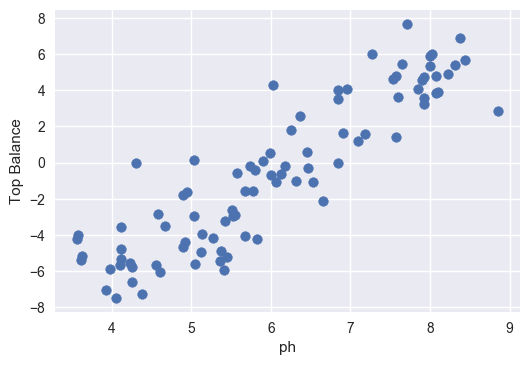

In [12]:
import matplotlib.pyplot as plt
from gneiss.util import match
%matplotlib inline
top_balance = ols_model.balances.iloc[:, 0]
top_balance, ph = match(top_balance, mapping.ph)
plt.scatter(ph, top_balance)
plt.xlabel('ph')
plt.ylabel('Top Balance')

Now we'll want to see how good of a prediction the regression can perform.
We'll visualize the raw heatmap next to the predicted heatmap.  The rows and columns will be sorted using the pH information.  We'll be using the function [`niche_sort`](https://github.com/biocore/gneiss/blob/master/gneiss/sort.py#L67) to handle this.

In [13]:
from gneiss.sort import niche_sort
observed_table = niche_sort(otu_table, mapping.ph)

For comparison, we'll want to visualize the predicted microbial proportions.  Note the `project=True` parameter allows 
the predictions to be returned as proportions, rather than as balances.

In [14]:
predicted_table = ols_model.predict(project=True)
predicted_table = predicted_table.reindex(index=observed_table.index, 
                                          columns=observed_table.columns)

We'll plot the observed OTU counts, and the predicted OTU proportions side by side.  

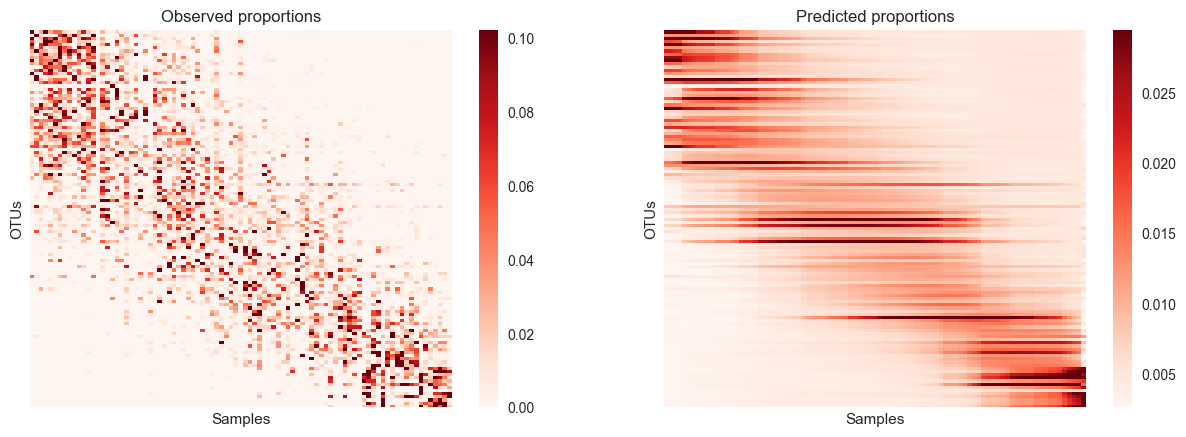

In [15]:
from skbio.stats.composition import closure
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
sns.heatmap(closure(observed_table.T), robust=True, ax=ax1, cmap='Reds')
sns.heatmap(predicted_table.T, robust=True, ax=ax2, cmap='Reds')
ax1.set_title('Observed proportions')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Samples')
ax1.set_ylabel('OTUs')
ax2.set_title('Predicted proportions')
ax2.set_xlabel('Samples')
ax2.set_ylabel('OTUs')

From this, it is clear that the linear regression on balances can capture the overall trends of OTUs vs pH. 
Ecologically, this makes sense.  Bacteria tend to prefer to live in specific ranges of pH.  So it isn't entirely surprising that microbial abundances can be predicted from pH.  At the same time, the pattern was not obviously apparent until linear regressions on balances were applied.

In short, applying linear regressions to balances are useful for studying gradients.  